# Switching dynamics

In the case of the switching dynamics we assume that the reward probability $p_{t}$ changes suddenly but is otherwise constant. We can express the dynamics of reward probabilities as 
\begin{equation}
    p_{t} \sim \left\{ \begin{array}{cc}
        Beta(1, 1) & \textrm{for } j_{t-1} = 1  \\
        \delta(p_{t} - p_{t-1}) & \textrm{for } j_{t-1} = 0
    \end{array}
    \right.
\end{equation}
where $Beta(1, 1)$ denotes beta (uniform) distribution, and $\delta(x)$ Dirac's delta function. Similarly, we will express the transition probability of the change point variable $j_{t}$ as
\begin{equation}
    p(j_{t}=j|j_{t-1}) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1} = 1  \\
        \rho^{j}(1-\rho)^{1-j} & \textrm{for } j_{t-1} = 0
    \end{array}
    \right.
\end{equation}
where $\delta_{j,0} = 1$ for $j=0$.

In [1]:
import sys
import numpy as np

import jax.numpy as jnp
from jax import random, lax, nn, ops

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

sns.set(style="ticks", context="notebook")
plt.rcParams.update({'axes.spines.right': False, 'axes.spines.top': False, 'lines.linewidth': 2., 'axes.xmargin': 0.01})
%matplotlib inline

In [2]:
# define process simulator
K = 1  # we will use bandits with one arm only

def simulator(process, N=1, T=1000):
    def sim_fn(carry, t):
        rng_key, states, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, states = process(t, choices, states, _rng_key)
        
        return (rng_key, states, choices), {'rewards': outcomes, 'probs': states[0], 'changes': states[1]}
    
    rng_key = random.PRNGKey(4488342)
    states = [random.uniform(rng_key, shape=(N, K)), jnp.zeros(K, dtype=jnp.int32)]
    choices = jnp.zeros(N, dtype=jnp.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, choices), jnp.arange(T))
    
    sequence['probs'] = jnp.concatenate([states[0][None], sequence['probs']], 0)[:-1]
    sequence['changes'] = jnp.concatenate([states[1][None], sequence['changes']], 0)[:-1]
    
    return sequence

In [3]:
# import generative process
from bandits.environment import generative_process_swtch2

log_p_jj = lambda rho: jnp.log(np.array([[1 - rho, rho], [1., 0.]]))
def process_swtch(*args, rho=0.01):
    return generative_process_swtch2(*args, log_p_jj(rho))

-462.71112


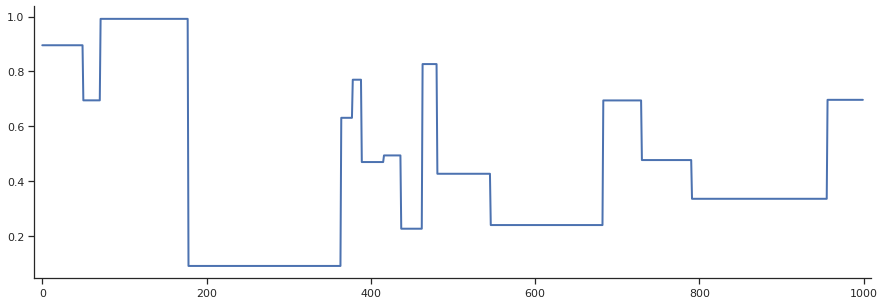

In [4]:
N = 1
sequence = simulator(process_swtch, N=N)
probs_swtch = sequence['probs']

plt.figure(figsize=(15, 5))
plt.plot(probs_swtch.flatten(), lw=2)

obs_swtch = sequence['rewards']

obs = obs_swtch.astype(np.int32).flatten()
log_like_swtch = np.log(probs_swtch.flatten()) * obs + np.log(1 - probs_swtch.flatten()) * (1 - obs)
print(log_like_swtch.sum())

# Drifting dynamics

In the case of the drifting dynamics we assume that the reward probability $p_{t}$ continuously following a random walk. We can express the dynamics of reward probabilities as 
\begin{equation}
    \textrm{logit}(p_{t}) = \textrm{logit}(p_{t-1}) + \sqrt{\sigma} \cdot n_t 
\end{equation}
where $n_t \sim \mathcal{N}(0, 1)$ and $p_0 \sim U(0, 1)$. 

We will consider here the case when $\sigma=0.01$.

In [5]:
from bandits.environment import generative_process_drift

def process_drft(*args, sigma=.01):
    return generative_process_drift(*args, sigma=sigma)

-430.46912


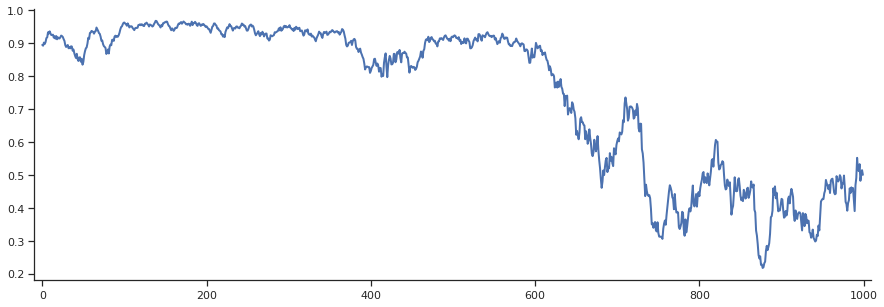

In [6]:
sequence = simulator(process_drft, N=N)

probs_drft = sequence['probs']

plt.subplots(figsize=(15, 5))
plt.plot(probs_drft.flatten())

obs_drft = sequence['rewards']

obs = obs_drft.astype(np.int32).flatten()
log_like_drft = np.log(probs_drft.flatten()) * obs + np.log(1 - probs_drft.flatten()) * (1 - obs)

print(log_like_drft.sum())

## [Hierarchical variational SMiLe](https://direct.mit.edu/neco/article/33/2/269/95646/Learning-in-Volatile-Environments-With-the-Bayes)
To define the hierarchical generative model we will introduce prior beliefs over change probability $\rho$ and an 
auxiliary switch variable $e_t$ that encodes presence of the switch
\begin{equation}
\begin{split}
\rho & \sim \mathcal{Be}\left(a, b\right) \\
p(j_t|e_t, j_{t-1}, \rho) & = \left\{ \begin{array}{ll} \rho^{\delta_{f_t, 1-f_{t-1}}}(1-\rho)^{\delta_{f_t, f_{t-1}}} & \textrm{if } e_{t}=0 \\ 
\delta_{j_t, 0} & \textrm{if } e_{t} = 1 \end{array} \right. \\
e_t & \sim p(e_t|j_{t-1}) = \delta_{e_t, j_{t-1}} \\
p(\theta_t|\theta_{t-1}, e_t) & = \left\{ \begin{array}{ll} \delta(\theta_t - \theta_{t-1}) 
& \textrm {if } e_t = 0 \\ \mathcal{Be}\left(\frac{1}{2}, \frac{1}{2} \right) & \textrm{if } e_t=1 \end{array} \right. \\
\theta_t & \sim p(\theta_t|\theta_{t-1}, e_t) \\
o_t & \sim \theta_t^{o_t} (1 - \theta_t)^{1-o_t}
\end{split}
\end{equation}

Assuming the following approximate factorisation of the posterior 
$$ p(\theta_t, j_t, e_t, \rho|o_{t:1}) \approx Q(\theta_t) Q(j_t, e_t) Q(\rho)$$
where
\begin{equation}
\begin{split}
Q(\rho) &= \mathcal{Be}\left(a_{t}, b_{t}\right)\\
Q(j_t, e_t) & = \left\{ \begin{array}{ll} (1 - \omega_t)^{1-j_t} \omega_t^{j_t} (1 - \eta_t) & \textrm{if } e_{t}=0 \\ 
(1 - \omega_t)^{1-j_t} \omega_t^{j_t} \eta_t & \textrm{if } e_{t} = 1 \end{array} \right. \\
Q(\theta_t) & = \mathcal{Be}\left(\alpha_{t}, \beta_{t} \right)
\end{split}
\end{equation}
we can express the predictive joint distribution as 
$$ p(\theta_t, j_t, e_t, \rho|o_{t-1:1}) = p(\theta_t|e_t, o_{t-1:1}) p(j_t|e_t, \rho) p(e_t|o_{t-1:1}) p(\rho|o_{t-1:1}) $$

where
\begin{equation}
\begin{split}
p(\rho|o_{t-1:1}) &= \mathcal{Be}\left(a_{t-1}, b_{t-1}\right) \equiv Q(\rho) \\
p(j_t, e_t| \rho, o_{t-1:1}) & = \left\{ \begin{array}{ll} (1 - \rho)^{1-j_t} \rho^{j_t} (1 - \omega_{t-1}) & \textrm{if } e_{t}=0 \\ 
\delta_{j_t, 0} \omega_{t-1} & \textrm{if } e_{t} = 1 \end{array} \right. \\
p(\theta_t| e_t, o_{t-1:1}) & = \left\{ \begin{array}{ll} \mathcal{Be}\left(\alpha_{t-1}, \beta_{t-1} \right)
& \textrm {if } e_t = 0 \\ \mathcal{Be}\left(\frac{1}{2}, \frac{1}{2} \right) & \textrm{if } e_t=1 \end{array} \right. \\
\end{split}
\end{equation}

If we notice that one can easily obtain the condition posterior over $\theta_t$ as 
\begin{equation}
p \left( \theta_t|e_t, o_{t:1} \right) = \left\{ \begin{array}{ll} \mathcal{Be}\left(\alpha_{t-1} + o_t, 1 - o_t + \beta_{t-1} \right)
& \textrm {if } e_t = 0 \\ \mathcal{Be}\left(o_t + \frac{1}{2}, (1-o_t) + \frac{1}{2} \right) & \textrm{if } e_t=1 \end{array} \right.
\end{equation}

we can express the joint posterior as 

\begin{equation}
    p\left(\theta_t, j_t, f_t, \rho|o_{t:1}\right) \propto p(\theta_t|e_t, o_{t-1:1})p(o_t|e_t, o_{t-1:1}) p(j_t, e_t| \rho, o_{t-1:1})p(\rho| o_{t-1:1})
\end{equation}

Hence the approximate posterior can be obtained as the minimiser of the following variational energy

\begin{equation}
    F[Q] = \sum_{e_t, j_t} \int  Q(\theta, j_t, e_t, \rho) \ln \frac{ Q(\theta, j_t, e_t, \rho)}{p(o_t \theta_t, j_t, e_t, \rho| o_{t-1:1})} \textrm{d}\theta_t \textrm{d}\rho
\end{equation}

The update equations correspond to the following relations
\begin{equation}
\begin{split}
        Q(\rho) &\propto p\left(\rho|o_{t-1:1} \right)e^{\sum_{j_t,e_t} Q(j_t, e_t)\ln p\left(j_t, e_t|\rho, o_{t-1:1}\right)}\\
        a_t &= a_{t-1} + Q(j_t=1, e_t=0) \\
        b_t &= b_{t-1} + Q(j_t=0, e_t=0) \\
        Q(j_t, e_t) &\propto p(o_t|e_t, o_{t-1:1}) \bar{p}(j_t, e_t| o_{t-1:1})\\
        \eta_t &= \frac{\frac{1}{2}\omega_{t-1}}{\frac{1}{2}\omega_{t-1} + \mu_{t-1}^{o_t} (1-\mu_{t-1})^{1-o_t}(1-\omega_{t-1})}, \quad \mu_{t-1} = \frac{\alpha_{t-1}}{\alpha_{t-1} + \beta_{t-1}}\\
        \omega_t &= m_{t-1} (1 - \eta_t)\\
        Q(\theta_t) &= e^{\sum_{e_t} Q(e_t)\ln p(\theta_t|e_t, o_{t:1})}\\
        \alpha_t &= (1 - \eta_t) \cdot \alpha_{t-1} + \eta_t \alpha_0 + o_t \\
        \beta_t &= (1 - \eta_t) \cdot \beta_{t-1} + \eta_t \beta_0 + (1-o_t)
\end{split}
\end{equation}

where 
\begin{equation} 
\bar{p}(j_t, e_t| o_{t-1:1}) = \left\{ \begin{array}{ll} (1 - m_{t-1})^{1-j_t} m_{t-1}^{j_t} (1 - \omega_{t-1}) & \textrm{if } e_{t}=0 \\ \delta_{j_t, 0} \omega_{t-1} & \textrm{if } e_{t} = 1 \end{array} \right., \quad m_{t-1} = \frac{a_{t-1}}{a_{t-1} + b_{t-1}}.
\end{equation}

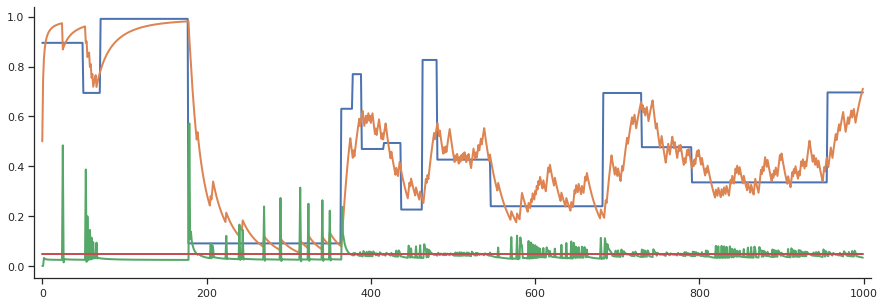

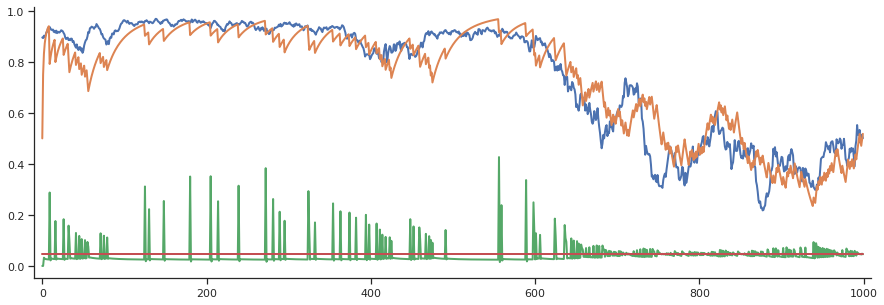

In [7]:
from jax.scipy.special import digamma
def learning(outcomes):
    alpha = [.5]  # we start with Jeffrey priors
    beta = [.5]
    
    a =  [1.]  # prior probability of change probability is biased towards small values
    b  = [20.]
    
    m = [a[-1]/(a[-1] + b[-1])]
    
    mu = [.5]
    eta = [0.]
    omega = [0.]
    for o in outcomes:
        ll0 = mu[-1] * o + (1 - mu[-1]) * (1-o)
        ll1 = .5
        
        norm = ll1 * omega[-1] + ll0 * (1 - omega[-1])
        et_post = ll1 * omega[-1] / norm
        om_post = m[-1] * (1 - et_post)
        
        alpha.append(alpha[-1] * ( 1 - et_post) + et_post * alpha[0] + o)
        beta.append(beta[-1] * (1 - et_post) + et_post * beta[0] + (1 - o))
        mu.append(alpha[-1]/(alpha[-1] + beta[-1]))
        eta.append(et_post)
        omega.append(om_post)
        
        a.append(a[-1] + omega[-1])
        b.append(b[-1] + 1 - eta[-1] - omega[-1])
        m.append(a[-1]/(a[-1] + b[-1]))
        
    return np.array(mu), np.array(eta), np.array(m)

F_swtch = []  # free energy for switching dynamics
F_drft = []  # free energy for drift dynamics
learning_names = []

log_likes = []

for i in range(N):

    mu, eta, m = learning(obs_swtch[:, i, 0])
    
    if i == 0:
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(probs_swtch[:, i])
        ax.plot(mu[:-1])
        ax.plot(eta[:-1])
        ax.plot(m[:-1])
    log_like = mu[:-1] * obs_swtch[:, i, 0] + (1 - mu[:-1]) * (1 - obs_swtch[:, i, 0])
    log_likes.append(np.log(log_like))
    
F_swtch.append(np.array(log_likes).T)
learning_names.append("HierarchicalSMiLe")

log_likes = []

for i in range(N):

    mu, eta, m = learning(obs_drft[:, i, 0])
    
    if i == 0:
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(probs_drft[:, i])
        ax.plot(mu[:-1])
        ax.plot(eta[:-1])
        ax.plot(m[:-1])
            
    log_like = m[:-1] * obs_drft[:, i, 0] + (1 - m[:-1]) * (1 - obs_drft[:, i, 0])
    log_likes.append(np.log(log_like))
    
F_drft.append(np.array(log_likes).T)

## [A simple model for learning in volatile environments](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007963)

Implementation of the model introduced here

Piray, Payam, and Nathaniel D. Daw. "A simple model for learning in volatile environments." PLoS computational biology 16.7 (2020): e1007963.


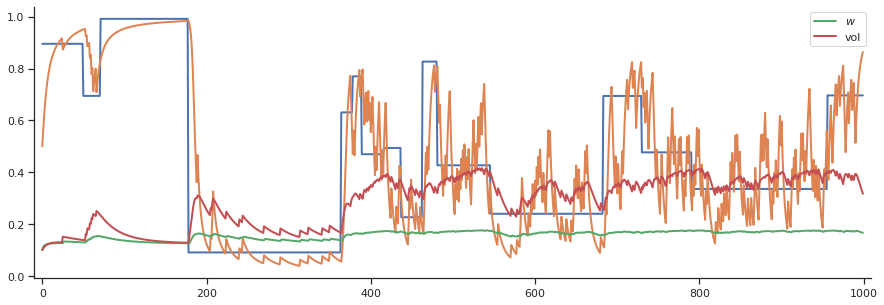

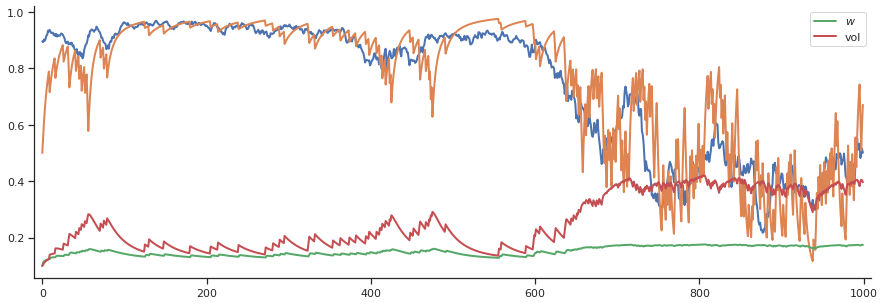

In [8]:
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

def learning(outcomes, ω=.25, λ=.1):
    m = [0]
    w = [.1]
    v = [.1]
    
    for o in outcomes:
        hat_w = w[-1] + v[-1]
        k = hat_w/(hat_w + ω)
        α = jnp.sqrt(hat_w)
        
        δm = α * (o - sigmoid(m[-1]))
                
        m.append(m[-1] + δm)
        
        w1 = (1 - k) * w[-1]
        
        w.append((1 - k) * hat_w)
        
        v.append(v[-1] + λ * (δm**2 + w[-2] + w[-1] - 2*w1 -v[-1]))
        
    return jnp.array(m), jnp.array(w), jnp.array(v)

log_likes = []

for i in range(N):

    m, w, v = learning(obs_swtch[:, i, 0])
    
    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.plot(probs_swtch[:, i])
        plt.plot(sigmoid(m[:-1]))
        plt.plot(w[:-1], label=r'$w$')
        plt.plot(v[:-1], label=r'vol')
        plt.legend()
    
    bar_x = m[:-1]/jnp.sqrt(1 + jnp.pi * (w[:-1] + v[:-1])/8)
    
    log_likes.append(jnp.log(sigmoid(bar_x)) * obs_swtch[:, i, 0] +\
                     jnp.log(1 - sigmoid(bar_x)) * ( 1 - obs_swtch[:, i, 0]))
    
    
F_swtch.append(np.array(log_likes).T)
learning_names.append("SimpleVol")

log_likes = []

for i in range(N):

    m, w, v = learning(obs_drft[:, i, 0])
    
    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.plot(probs_drft[:, i])
        plt.plot(sigmoid(jnp.array(m[:-1])))
        plt.plot(w[:-1], label=r'$w$')
        plt.plot(v[:-1], label=r'vol')
        plt.legend()
    
    bar_x = m[:-1]/jnp.sqrt(1 + jnp.pi * (w[:-1] + v[:-1])/8)
    
    log_likes.append(jnp.log(sigmoid(bar_x)) * obs_drft[:, i, 0] +\
                     jnp.log(1 - sigmoid(bar_x)) * ( 1 - obs_drft[:, i, 0]))
    
F_drft.append(np.array(log_likes).T)

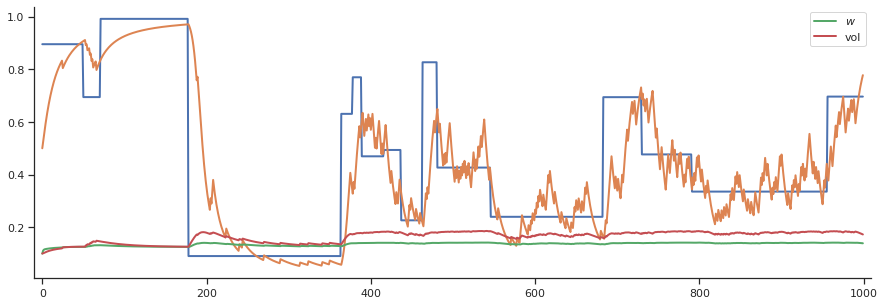

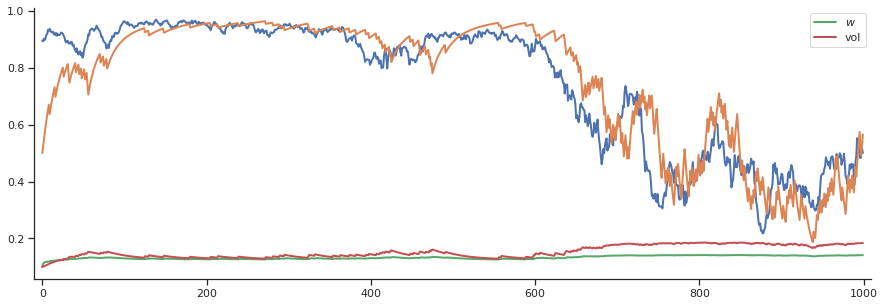

In [9]:
# This is the same model as above but with slightly different way of computing the learning rate than what they 
# propose in the paper

def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

def learning(outcomes, ω=.25, λ=.1):
    m = [0.]
    w = [.1]
    v = [.1]
    
    for o in outcomes:
        hat_w = w[-1] + v[-1]
        γ = 1./jnp.sqrt(1. + jnp.pi * hat_w/8)
        
        α = hat_w * γ
        pred = sigmoid(γ * m[-1])
        δm = α * (o - pred)
        m.append(m[-1] + δm)
        
        k = hat_w/(hat_w + ω)
        
        w1 = (1 - k) * w[-1]
        w.append((1 - k) * hat_w)
                
        v.append(v[-1] + λ * (δm**2 + w[-2] + w[-1] - 2*w1 - v[-1]))
        
    return jnp.array(m), jnp.array(w), jnp.array(v)

log_likes = []

for i in range(N):

    m, w, v = learning(obs_swtch[:, i, 0])
    
    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.plot(probs_swtch[:,i])
        plt.plot(sigmoid(m[:-1]))
        plt.plot(w[:-1], label=r'$w$')
        plt.plot(v[:-1], label=r'vol')
        plt.legend()
        
    bar_x = m[:-1]/jnp.sqrt(1 + jnp.pi * (w[:-1] + v[:-1])/8)
    
    log_likes.append(jnp.log(sigmoid(bar_x)) * obs_swtch[:, i, 0] +\
                     jnp.log(1 - sigmoid(bar_x)) * ( 1 - obs_swtch[:, i, 0]))
    
F_swtch.append(np.array(log_likes).T)
learning_names.append("SimpleVol2")

log_likes = []

for i in range(N):

    m, w, v = learning(obs_drft[:, i, 0])
    
    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.plot(probs_drft[:,i])
        plt.plot(sigmoid(jnp.array(m[:-1])))
        plt.plot(w[:-1], label=r'$w$')
        plt.plot(v[:-1], label='vol')
        plt.legend()
    
    bar_x = m[:-1]/jnp.sqrt(1 + jnp.pi * (w[:-1] + v[:-1])/8)
    
    log_likes.append(jnp.log(sigmoid(bar_x)) * obs_drft[:, i, 0] +\
                     jnp.log(1 - sigmoid(bar_x)) * ( 1 - obs_drft[:, i, 0]))
    
F_drft.append(np.array(log_likes).T)

Although it seems like the above variational algorithms do a fairly good job in estimating the outcome probability. However, some variants used above are a bit slow in adjusting to changes as they underestimate uncertainty. One can see this using the following alghoritm that approximate likelihood with a set of descrete points, and implements a close to exact filtering algorithm.

Lets assume that reward probability can have only discrete value, for example 

$$ p \in P = \left\{\frac{1}{2D}, \ldots, 1-1/D\right\}$$

where $D$ denotes number of discrete values and $|P| = D$.

Hence if we associate different possible values with descrete hidden states $k_t$ we can describe the whole problem as a hierarchical hidden markov model. In this case the state transition matrix is given as 

$$ p(k_t|k_{t-1}, j_{t-1}=0) = I_D$$

that is, states do not change in the absence of a change point, and

$$ p(k_t|k_{t-1}, j_{t-1}=1) = \frac{1}{D-1} \left( J_{D} - I_D \right) $$

where $J_D$ stands for a D-dimensional matrix of ones, and $I_D$ for a D-dimensional identity matrix.

This way one can define an exact update of beliefs using Bayes rule

$$ p(k_t, j_t|o_{1:t}) \propto p(o_t|k_t)p(k_t,j_t|o_{1:t-1})$$

where 

$$ p(o_t|k_t=k) = p_k^{o_t}(1-p_k)^{1-o_t}$$

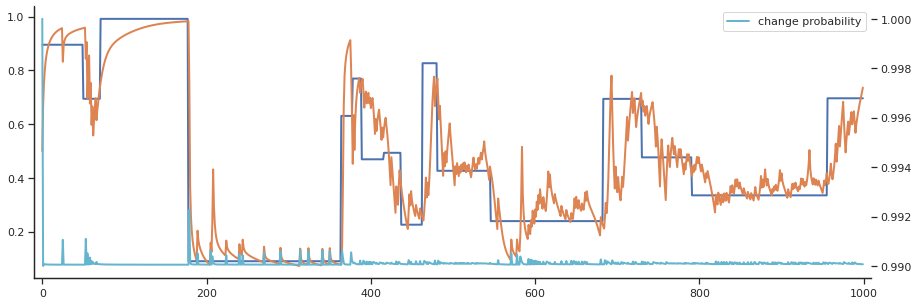

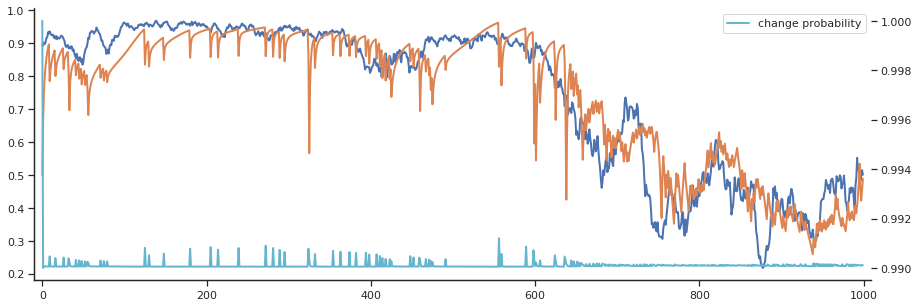

In [10]:
D = 100
rho = 0.01
p_jj = jnp.exp(log_p_jj(rho))
p_jss = jnp.stack([jnp.eye(D), (jnp.ones((D,D)) - jnp.eye(D))/(D-1)], 0)

def learning(outcomes, D=10):
    likelihoods = jnp.arange(1/(2*D), 1., 1/D)[:, None]
    
    def scan_fn(probs, o):
        pred = jnp.einsum('ijk,il,ji->kl', p_jss, p_jj, probs)
        ol = likelihoods**o * (1 - likelihoods)**(1 - o)
        post = ol * pred
        
        m = jnp.sum(probs * likelihoods)
        e = probs.sum(-2)[-1]
        
        q = post/post.sum()
        return q, (m, e, q)

    probs = jnp.ones((D, 1))/D * jnp.array([1., 0])
    _, sequence = lax.scan(scan_fn, probs, outcomes)
        
    return sequence[0], sequence[1], sequence[-1]

log_likes = []

for i in range(N):
    m, e, post = learning(obs_swtch[:, i, 0], D=D)

    if i == 0:
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(probs_swtch[:, i])
        ax.plot(m)
        axt = ax.twinx()
        axt.plot(1-e, 'c', label='change probability')
        axt.legend()
    
    log_like = m * obs_swtch[:, i, 0] + (1 - m) * (1 - obs_swtch[:, i, 0])
    log_likes.append(np.log(log_like))

F_swtch.append(np.array(log_likes).T)
learning_names.append("HMM")

log_likes = []

for i in range(N):
    m, e, post = learning(obs_drft[:, i, 0], D=D)

    
    if i == 0:
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(probs_drft[:,i])
        ax.plot(m)
        axt = ax.twinx()
        axt.plot(1 - e, 'c', label='change probability')
        axt.legend()
        
    log_like = m * obs_drft[:, i, 0] + (1 - m) * (1 - obs_drft[:, i, 0])
    log_likes.append(np.log(log_like))

F_drft.append(np.array(log_likes).T)

Interestingly, although we consider only switching dynamics in the generative model, we get a fairly good estimates of the underlying probabilities in the drifting environment.

Above we have assumed that the agent already knows the change point probability, however in general this will be a hidden quantity for the agent. Here we will add another level to the HMM which estimates the change point probability also. Similar to likelihoods we can discretise the change point probability $\rho$ and assume that 

$$ \rho \in R = \left\{ \frac{1}{2M}, \ldots, 1-\frac{1}{M} \right\}, \qquad |R| = M$$

We will associate different possible values with descrete hidden states $r_t$, and express the change point transition matrix as 

\begin{equation}
    p(j_{t}=j|j_{t-1}, r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1,l} = 1  \\
        \rho_r^{j}(1-\rho_r)^{1-j} & \textrm{for } j_{t-1,l} = 0
    \end{array}
    \right.
\end{equation}

and the $r_t$ transition probabability as a 1D random walk

\begin{equation}
    p(r_t=q|r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{q, r} & \textrm{with pr. } 1 - \kappa  \\
        \delta_{q, r + 1} & \textrm{with pr. } \kappa/2 \\
        \delta_{q, r - 1} & \textrm{with pr. } \kappa/2
    \end{array}
    \right.
\end{equation}

The belief update becomes

$$ p(k_t, j_t, r_t|o_{1:t}) \propto p(o_t|k_t)p(k_t,j_t, r_t|o_{1:t-1})$$

where we will assume a priory a bias toward small change probabilities, hence 

$$ p(r_0 = r) \propto e^{-\lambda r} $$

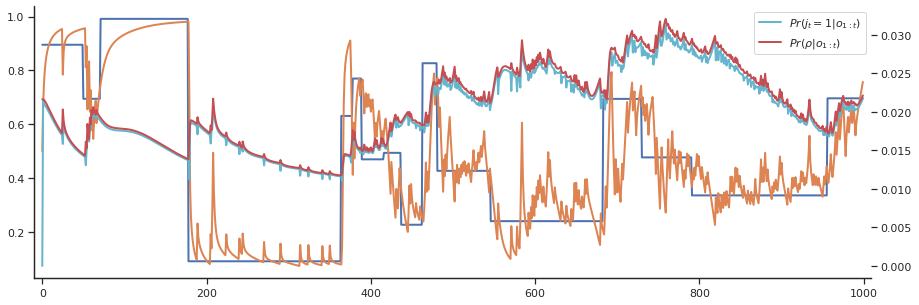

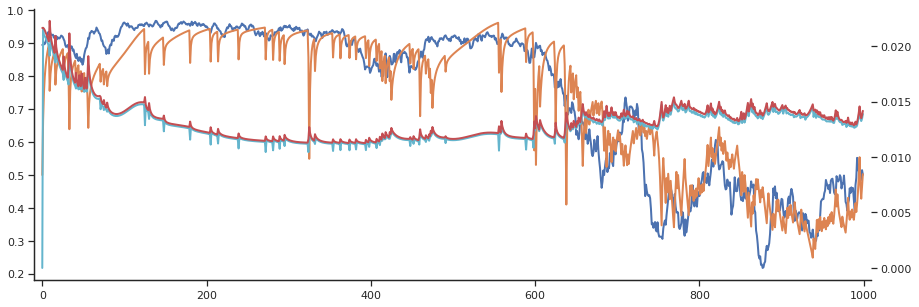

In [11]:
def learning(outcomes, D=10, M=10):
    
    p_jss = jnp.stack([np.eye(D), (np.ones((D,D)) - np.eye(D))/(D-1)], 0)
    
    likelihoods = jnp.arange(1/(2*D), 1., 1/D)[:, None, None]
    
    rho = jnp.arange(1/(2*M), 1, 1/M)
    stay = jnp.stack([1 - rho, rho], -1)
    change = jnp.array([1., 0.])[None].repeat(M, -2)
    p_rjj = jnp.stack([stay, change], -2)
    
    kappa = 1e-3
    p_rr = (1 - kappa) * jnp.eye(M) + kappa * (jnp.diag(jnp.ones(M-1), 1) + jnp.diag(jnp.ones(M-1), -1))/2
    p_rr = ops.index_update(p_rr, ops.index[[0, -1], [1, -2]], kappa)
    
    def scan_fn(probs, o):
        pred = jnp.einsum('jsk,rjl,rq,sjr->klq', p_jss, p_rjj, p_rr, probs)
        ol = likelihoods**o * (1 - likelihoods)**(1 - o)
        post = ol * pred
        
        m = jnp.sum(probs * likelihoods)
        e = probs[:, -1].sum()
        r = jnp.sum(probs * rho)
        
        q = post/post.sum()
        return q, (m, e, r, q)
    
    r0 = jnp.exp(- 1 * jnp.arange(M)) #np.eye(M)[0]
    probs = jnp.ones((D, 1, 1))/D * jnp.array([1., 0])[:, None] * r0/r0.sum()
    _, sequence = lax.scan(scan_fn, probs, outcomes)
        
    return sequence[0], sequence[1], sequence[2], sequence[3]

D = 100
M = 50

log_likes = []

for i in range(N):
    m, e, r1, post = learning(obs_swtch[:, i, 0], D=D, M=M)
    
    if i == 0:
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(probs_swtch[:, i])
        ax.plot(m)
        axt = ax.twinx()
        axt.plot(e, 'c', label=r'$Pr(j_t=1|o_{1:t})$')
        axt.plot(r1, 'r', label=r'$Pr(\rho|o_{1:t})$')
        axt.legend()
        
    log_like = np.array([m[j]*o + (1-m[j])*(1-o) for j, o in enumerate(obs_swtch[:, i, 0])])
    log_likes.append(np.log(log_like))
    
F_swtch.append(np.array(log_likes).T)
learning_names.append("HierarchicalHMM")

log_likes = []

for i in range(N):

    m, e, r2, post = learning(obs_drft[:, i, 0], D=D, M=M)
    
    if i == 0:
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(probs_drft[:,i])
        ax.plot(m)
        axt = ax.twinx()
        axt.plot(e, 'c', label=r'$Pr(j_t=1|o_{1:t})$')
        axt.plot(r2, 'r', label=r'$Pr(\rho|o_{1:t})$')
        
    log_like = np.array([m[j]*o + (1-m[j])*(1-o) for j, o in enumerate(obs_drft[:, i, 0])])
    log_likes.append(np.log(log_like))
F_drft.append(np.array(log_likes).T)

Well, so far so good. We can implement the discretised generative model for various dynamic MABs or try to figure out a equally good varaitional inference algo.

Instead of discretizing the reward probability $p$, we can try to learn it using a Beta distribution as a conjugate prior
\begin{equation}
p(o_t,\theta|o_{1:t-1}) = p(o_t|\theta_t)p(\theta_t|o_{1:t-1})
\end{equation}
where the likelihood is defines as a Bernoulli distribution
\begin{equation}
p(o_t|\theta) = \theta_t^{1-o_t}\left( 1 - \theta_t \right)^{o_t}
\end{equation}
and the prior as Beta distribution
\begin{equation}
p(\theta|o_{1:t-1}) = \frac{1}{B(\alpha^\prime_t, \beta^\prime_t)} \theta^{\beta^\prime_t-  1} \left(1 - \theta \right)^{\alpha^\prime_t-1}.
\end{equation}

Hence, the expected reward probability, $p(o_t=1|o_{1:t-1})$, corresponds to 

$$\frac{\alpha^\prime_t}{\alpha^\prime_t+\beta^\prime_t}$$

As the Beta distribution is the conjugate prior of the Bernoulli distribution, thus the posterior will also correspond to a Beta distribution 

\begin{equation}
p(\theta_t|o_{1:t}) = \frac{1}{B(\alpha_t, \beta_t)}\left(1 - \theta_t\right)^{\alpha_t-1}\theta_t^{\beta_t-1}
\end{equation}

hence yielding the followin iterative update equations

\begin{equation}
\begin{split}
    \alpha_t &= \alpha^\prime_t + o_t \\
    \beta_t &= \beta^\prime_t + 1 - o_t
\end{split}
\end{equation}

To introduce forgeting of old observations (e.g. because recently environment changed) we can express the prior at $t$ as a functional of the posterior at time $t-1$, such that

\begin{equation}
p(\theta_t|o_{1:t-1}) = \int d\theta_{t-1} p(\theta_t|\theta_{t-1}, \kappa) p(\theta_{t-1}|o_{1:t-1}) = p(\theta_{t}|o_{1:t-1}, \kappa) \propto Beta(\alpha_{t-1}, \beta_{t-1})^\kappa Beta(\alpha_0, \beta_0)^{1-\kappa}
\end{equation}
hence 

\begin{equation}
\begin{split}
    \alpha^\prime_t &= \kappa \alpha_{t-1} + (1 - \kappa)\alpha_0 \\
    \beta^\prime_t &= \kappa \beta_{t-1} + (1 - \kappa)\beta_0
\end{split}
\end{equation}

If we set $m_t = \frac{\alpha_t}{\nu_t}$ and $\nu_t = \alpha_t + \beta_t$ we can express the update equations 
as

\begin{equation}
\begin{split}
    m_t &= m_{t-1} + \frac{1}{\nu_{t}} \left(o_t - m_{t-1} \right) + \frac{2 \cdot( 1 - \kappa)}{\nu_{t}} \left(\frac{1}{2} - m_{t-1} \right) \\
    \nu_t & = \kappa \nu_{t-1} + 2 * (1 - \kappa) + 1
\end{split}
\end{equation}

Notice that in the above equations $\frac{1}{\nu_t}$ corresponds to the learning rate. In the limit of large number of trials $t \gg 1$ we get that

$$ \nu^* = \kappa \nu^* + 1 - \kappa + 1 \rightarrow \nu^* = 1 + \frac{1}{1-\kappa}$$

Which tells us that after many observation learning rate converges to $(1 - \kappa)/(2 - \kappa)$.

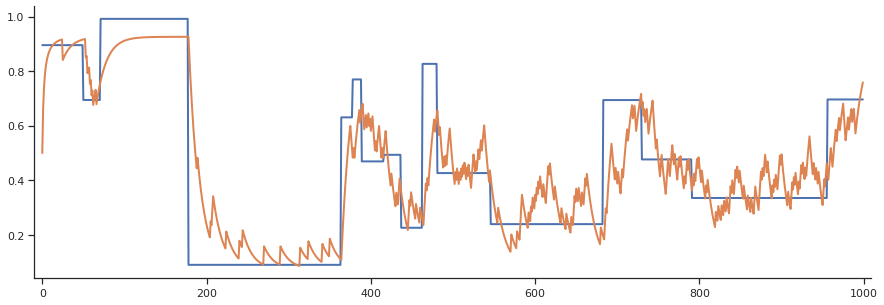

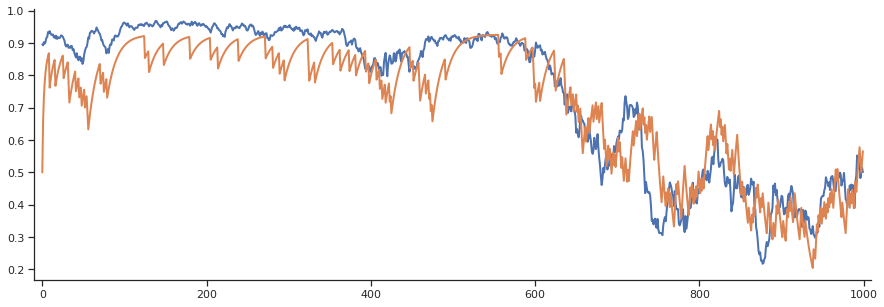

In [12]:
kappa = 0.92

def learning(outcomes):
    
    
    def scan_fn(carry, o):
        
        pred_p, pred_alpha = carry
        N = pred_p.shape[0]
        obs = o.astype(jnp.float32)
        alpha_0 = 1-obs + kappa * pred_alpha[:, 0] + 1 - kappa
        alpha_1 = obs + kappa * pred_alpha[:, 1] + 1 - kappa
        q_alpha = jnp.array([alpha_0, alpha_1]).T
        q_p = kappa * pred_alpha + 1 - kappa
        q_p /= q_p.sum(axis=-1)[:, None]
        
        return (q_p, q_alpha), {'prob': q_p, 'alpha': q_alpha}

    q_p_init = jnp.array(N*[[0.5,0.5]], dtype=jnp.float32)
    q_alpha_init = jnp.array(N*[[1, 1]], dtype=jnp.float32)
    carry = (q_p_init, q_alpha_init)
    _, sequence = lax.scan(scan_fn, carry, outcomes)
        
    return sequence

sequence = learning(obs_swtch[..., 0])
q_p = sequence['prob']
q_alpha = sequence['alpha']

for i in range(N):
    plt.subplots(figsize=(15, 5))
    plt.plot(probs_swtch[:, i])
    plt.plot(q_p[:, i, 1])

log_like = np.array([q_p[i, :, 1] * o + (1 - q_p[i, :, 1]) * (1 - o) for i, o in enumerate(obs_swtch[..., 0])])
log_like = np.log(log_like)
F_swtch.append(log_like)
learning_names.append("ParametricFixedKappa")

sequence = learning(obs_drft[..., 0])
q_p = sequence['prob']
q_alpha = sequence['alpha']

for i in range(N):
    plt.figure(figsize=(15, 5))
    plt.plot(probs_drft[:, i])
    plt.plot(q_p[:, i, 1])
    plt.show()

log_like = np.array([q_p[i,:,1]*o + (1-q_p[i,:,1])*(1-o) for i, o in enumerate(obs_drft[..., 0])])
log_like = np.log(log_like)
F_drft.append(log_like)

## Non-variational apparoch

Implementation of the method described in Lu, Xue, Niall Adams, and Nikolas Kantas. "On adaptive estimation for dynamic Bernoulli bandits." Foundations of Data Science 1.2 (2019): 197.

We are using the same notation as in the article.

The authors assume Bernoulli bandits, where the reward probability is estimated as
\begin{equation}
\hat{Y}_t = \frac{1}{w_{t}} \sum_{i=1}^{t} Y_{i}\prod_{p=1}^{i-1} \kappa_{p}
\end{equation}
depending on an adaptive discount/forgetting factors $\kappa_1, \ldots, \kappa_t$ and observations $Y_1, \ldots, Y_t$. This leads to the update equations
\begin{align}
\hat{Y}_{t} &= \frac{m_t}{w_t} \\
m_t &= \kappa_{t-1} m_{t-1} + Y_t \\
w_t &= \kappa_{t-1} w_{t-1} + 1
\end{align}
and $\kappa_t$ is computed via a single gradient descent step
\begin{align}
\kappa_t &= \kappa_{t-1} - \eta \Delta (L_{t}, \kappa_{1:t-2}) \\
L_{t} &= (\hat{Y}_{t-1}-Y_t)^2
\end{align}
where $L_t$ is a cost function, which could potentially have a different form. The gradient descent step is then
\begin{align}
\Delta (L_{t}, \kappa_{1:t-2}) &= 2(\hat{Y}_{t-1}-Y_t) \left(\frac{\dot{m}_{t-1} - \dot{w}_{t-1}\hat{Y}_{t-1}}{w_{t-1}}\right) \\
\dot{m}_{t} &= \kappa_{t-1}\dot{m}_{t-1} + m_{t-1} \\
\dot{w}_{t} &= \kappa_{t-1}\dot{w}_{t-1} + w_{t-1}
\end{align}

In terms of the notation above corresponding to the Beta posterior: $Y_t=o_t$, $m_t=\alpha_t$, $w_t=\nu_t$, and $\hat{Y}_t=m_t$. 

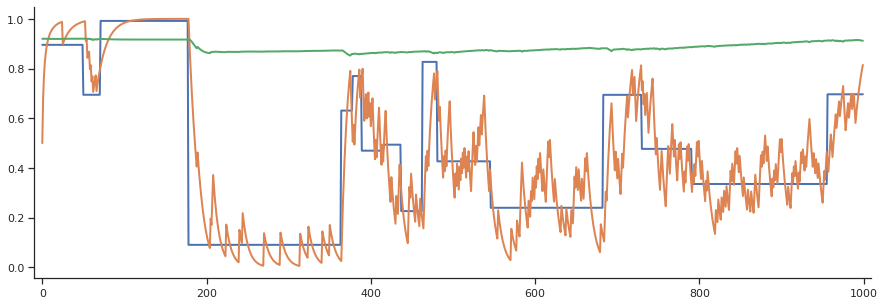

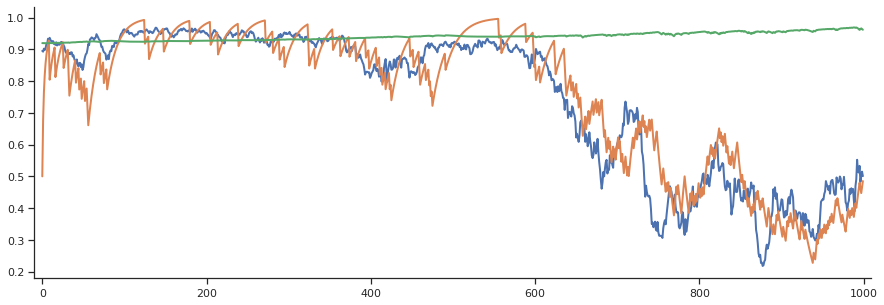

In [13]:
eta = 0.001

def learning(outcomes):
    
    
    def scan_fn(carry, o):
        pred_p, pred_alpha, kappa, m_dot, w_dot = carry
        
        obs = o.astype(jnp.int16)
        
        q_m_dot = kappa * m_dot + pred_alpha[:, 1]
        q_w_dot = kappa * w_dot + pred_alpha.sum(axis=1)
        
        d_kappa = 2 * (pred_p[:, 1] - o) * (m_dot - w_dot * pred_p[:, 1]) / pred_alpha.sum(axis=1)
        q_kappa = kappa - eta * d_kappa
        
        alpha_0 = (1-obs) + kappa * pred_alpha[:, 0]
        alpha_1 = obs + kappa * pred_alpha[:, 1]
        
        q_alpha = jnp.array([alpha_0, alpha_1]).T
        
        q_p = q_alpha
        q_p /= q_p.sum(axis=1)[:, None]
        
        return (q_p, q_alpha, q_kappa, q_m_dot, q_w_dot), {'prob': pred_p, 'alpha': pred_alpha, 'kappa': kappa}

    q_p_init = jnp.array(N*[[0.5,0.5]], dtype=jnp.float32)
    q_alpha_init = jnp.array(N*[[1, 1]], dtype=jnp.float32)
    kappa_init = jnp.array(N*[0.92])
    m_dot_init = jnp.array(N*[0.0])
    w_dot_init = jnp.array(N*[0.0])
    carry = (q_p_init, q_alpha_init, kappa_init, m_dot_init, w_dot_init)
    _, sequence = lax.scan(scan_fn, carry, outcomes)
        
    return sequence

sequence = learning(obs_swtch[..., 0])
q_p = sequence['prob']
q_alpha = sequence['alpha']
q_kappa = sequence['kappa']

for i in range(N):
    plt.figure(figsize=(15, 5))
    plt.plot(probs_swtch[:, i])
    plt.plot(q_p[:, i, 1])
    plt.plot(q_kappa[:, i])

log_like = np.array([q_p[i, :, 1]*o + (1 - q_p[i, :, 1])*(1 - o) for i, o in enumerate(obs_swtch[..., 0])])
log_like = np.log(log_like)
F_swtch.append(log_like)
learning_names.append("ParametricLu")

sequence = learning(obs_drft[..., 0])
q_p = sequence['prob']
q_alpha = sequence['alpha']
q_kappa = sequence['kappa']

for i in range(N):
    plt.figure(figsize=(15, 5))
    plt.plot(probs_drft[:, i])
    plt.plot(q_p[:, i, 1])
    plt.plot(q_kappa[:, i])

log_like = np.array([q_p[i, :, 1]*o + (1 - q_p[i, :, 1])*(1 - o) for i, o in enumerate(obs_drft[..., 0])])
log_like = np.log(log_like)
F_drft.append(log_like)

In [14]:
print("average negative log likelihoods for switching dynamics")
print("ref swtch", -log_like_swtch.sum(axis=0).mean())
for i,F in enumerate(F_swtch):
    print(learning_names[i], -np.array(F).sum(axis=0).mean())
print('====')
print("average negative log likelihoods for drifting dynamics")
print("ref drft", -log_like_drft.sum(axis=0).mean())
for i,F in enumerate(F_drft):
    print(learning_names[i], -np.array(F).sum(axis=0).mean())

average negative log likelihoods for switching dynamics
ref swtch 462.71112
HierarchicalSMiLe 526.66565
SimpleVol 535.6484
SimpleVol2 549.8361
HMM 512.29987
HierarchicalHMM 512.2516
ParametricFixedKappa 524.5678
ParametricLu 539.9275
====
average negative log likelihoods for drifting dynamics
ref drft 430.46912
HierarchicalSMiLe 2301.5808
SimpleVol 464.12677
SimpleVol2 455.13876
HMM 458.1239
HierarchicalHMM 459.1925
ParametricFixedKappa 459.60574
ParametricLu 461.08118


TODO: Implement the model proposed in 
Moens, Vincent, and Alexandre Zénon. "Learning and forgetting using reinforced Bayesian change detection." PLoS computational biology 15.4 (2019): e1006713.

Some initial text describint the model

## Adaptive learning rate

As $\kappa$ defines the long-term limit of the learning rate, in volatile environments that require adaptive learning rates, we can assume that $\kappa$ also changes over time, hence $\kappa \rightarrow \kappa_t$. Following the proposal of Moens et al. (eq. (10)) we will use the following hierarchical filter as a generative model 

$$ p(\theta_t, \kappa_t, \omega| o_{1:t}) \propto p(o_t|\theta_t) \bar{p}(\theta_t|\kappa_t)\bar{p}(\kappa_t| \omega) \bar{p}(\omega)$$

where 

\begin{equation}
\begin{split}
\bar{p}(\theta_t| \kappa_t) &\propto Beta(\alpha_{t-1}, \beta_{t-1})^{\kappa_t} Beta(\alpha_0, \beta_0)^{1-\kappa_t} \\
\bar{p}(\kappa_t| \omega) & \propto Beta(\alpha^{\kappa}_{t-1}, \beta^{\kappa}_{t-1})^{\omega} Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0)^{1-\omega}\\
\bar{p}(\omega) & = Beta(\alpha^{\omega}_{t-1}, \beta^{\omega}_{t-1})
\end{split}
\end{equation}

Assuming the mean-field approximation for the posterior, thus

$$ p(\theta_t, \kappa_t, \omega| o_{1:t}) \approx Q(\theta_t)Q(\kappa_t)Q(\omega)$$

we obtain the following update equations

\begin{equation}
\begin{split}
Q(\theta_t) &\propto exp\left\{ \hat{\kappa}_t \ln Beta(\alpha_{t-1}, \beta_{t-1}) + (1-\hat{\kappa}_t)  Beta(\alpha_0, \beta_0) \right\}  \\
Q(\kappa_t) & \propto exp \left\{ \hat{\omega} \ln Beta(\alpha^{\kappa}_{t-1}, \beta^{\kappa}_{t-1}) + (1-\hat{\omega}) \ln Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0) - \ln Z(\kappa_t) + \kappa_t E_{Q(\theta_t)}\left[\ln \frac{Beta(\alpha_{t-1}, \beta_{t-1})}{Beta(\alpha_0, \beta_0)}\right] \right\}\\
Q(\omega) &\propto \bar{p}(\omega) exp \left\{- \ln Z(\omega) + \omega E_{Q(\kappa_t)}\left[\ln \frac{Beta(\alpha^\kappa_{t-1}, \beta^{\kappa}_{t-1})}{Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0)}\right] \right\}
\end{split}
\end{equation}

Assuming the beta distribution for the approximate posterior over $\theta_t, \kappa_t$ and $\omega$ requires a non-conjugate message passing for defining parameter updates for $\alpha^{\kappa}_t, \beta^{\kappa}_t$ and $\alpha^{\omega}_t, \beta_t^{\omega}$. 

===========================================================================================================

\begin{equation}
\begin{split}
\bar{p}(\theta_t| \kappa_t) &\propto Beta(\alpha_{t-1}, \beta_{t-1})^{\kappa_t} Beta(\alpha_0, \beta_0)^{1-\kappa_t} \\
\bar{p}(\kappa_t| \omega) & \propto Beta(\alpha^{\kappa}_{t-1}, \beta^{\kappa}_{t-1})^{\omega} Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0)^{1-\omega}\\
\bar{p}(\omega) & = Beta(\alpha^{\omega}_{t-1}, \beta^{\omega}_{t-1})
\end{split}
\end{equation}

Assuming the mean-field approximation for the posterior, thus

$$ p(\theta_t, \kappa_t, \omega| o_{1:t}) \approx Q(\theta_t)Q(\kappa_t)Q(\omega)$$

we obtain the following update equations

\begin{equation}
\begin{split}
Q(\theta_t) &\propto exp\left\{ \hat{\kappa}_t \ln Beta(\alpha_{t-1}, \beta_{t-1}) + (1-\hat{\kappa}_t)  Beta(\alpha_0, \beta_0) \right\}  \\
Q(\kappa_t) & \propto exp \left\{ \hat{\omega} \ln Beta(\alpha^{\kappa}_{t-1}, \beta^{\kappa}_{t-1}) + (1-\hat{\omega}) \ln Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0) - \ln Z(\kappa_t) + \kappa_t E_{Q(\theta_t)}\left[\ln \frac{Beta(\alpha_{t-1}, \beta_{t-1})}{Beta(\alpha_0, \beta_0)}\right] \right\}\\
Q(\omega) &\propto \bar{p}(\omega) exp \left\{- \ln Z(\omega) + \omega E_{Q(\kappa_t)}\left[\ln \frac{Beta(\alpha^\kappa_{t-1}, \beta^{\kappa}_{t-1})}{Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0)}\right] \right\}
\end{split}
\end{equation}

Noting that the beta distribution for the approximate posterior over $\theta_t, \kappa_t$ and $\omega$ requires a non-conjugate message passing for defining parameter updates for $\alpha^{\kappa}_t, \beta^{\kappa}_t$ and $\alpha^{\omega}_t, \beta_t^{\omega}$. 

We obtain the following update equations
\begin{equation}
    \begin{split}
    \bar{\alpha}_t &= \hat{\kappa}_t \alpha_{t-1} + (1-\hat{\kappa}_t) \alpha_0\\
    \tilde{\alpha}_t & = o_t \\
    \alpha_t^\kappa & = \bar{\alpha}_t^\kappa + \tilde{\alpha}_t^\kappa \\
    \bar{\beta}_t^\kappa &= \hat{\omega} \beta_{t-1}^\kappa + (1-\hat{\omega}) \beta_0^\kappa \\
    \tilde{\beta}_t^\kappa & = 1 - o_t \\
    \beta_t & = \bar{\beta}_t + \tilde{\beta}_t
    \end{split}
\end{equation}

where $\hat{\kappa}_t = \int \kappa_t Q(\kappa_t) d \kappa_t$. Similarly, the parameters of $Q(\kappa_t)$ are updated as
\begin{equation}
    \begin{split}
    \bar{\alpha}_t^\kappa &= \hat{\omega} \alpha_{t-1}^\kappa + (1-\hat{\omega}) \alpha_0^\kappa\\
    \tilde{\alpha}_t^\kappa & = \tilde{\alpha}_t^\kappa + \epsilon \left(g_\alpha(\tilde{\alpha}_{t}^\kappa, \tilde{\beta}_{t}^\kappa) - \tilde{\alpha}_t^\kappa \right)  \\
    \alpha_t^\kappa & = \bar{\alpha}_t^\kappa + \tilde{\alpha}_t^\kappa \\
    \bar{\beta}_t^\kappa &= \hat{\omega} \beta_{t-1}^\kappa + (1-\hat{\omega}) \beta_0^\kappa \\
    \tilde{\beta}_t^\kappa & = \tilde{\beta}_t^\kappa + \epsilon \left( g_\beta(\tilde{\alpha}_t^\kappa,\tilde{\beta}_t^\kappa) - \tilde{\beta}_t^\kappa \right) \\
    \beta_t^\kappa & = \bar{\beta}_t^\kappa + \tilde{\beta}_t^\kappa
    \end{split}
\end{equation}

where $\hat{\omega} = \int \omega Q(\omega) d \omega$. Finally, the update of $Q(\omega)$ can be expressed as 
\begin{equation}
    \begin{split}
    \bar{\alpha}_t^\omega &= \alpha_{t-1}^\omega \\
    \tilde{\alpha}_t^\omega & = \tilde{\alpha}_t^\omega + \epsilon \left(g_\alpha(\tilde{\alpha}_{t}^\omega, \tilde{\beta}_{t}^\omega) - \tilde{\alpha}_t^\omega \right)  \\
    \alpha_t^\omega & = \bar{\alpha}_t^\omega + \tilde{\alpha}_t^\omega \\
    \bar{\beta}_t^\omega &= \beta_{t-1}^\omega \\
    \tilde{\beta}_t^\omega & = \tilde{\beta}_t^\omega + \epsilon \left( g_\beta(\tilde{\alpha}_t^\omega,\tilde{\beta}_t^\omega) - \tilde{\beta}_t^\omega \right) \\
    \beta_t^\omega & = \bar{\beta}_t^\omega + \tilde{\beta}_t^\omega
    \end{split}
\end{equation}